In [1]:
### Necessary libraries ###
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
import sklearn
import keras
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

C:\Users\FireAnt\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\FireAnt\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\FireAnt\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\FireAnt\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

In [2]:
### Load data ###
import pandas as pd
data = pd.read_csv('diabetic_data.csv')
print(data.shape)

(101766, 50)


In [3]:
### Feature types ###
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [4]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
### Number of classes in target values (readmitted) ###
data.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

In [6]:
'''Number of classes in Target values shows that we can treat them a ballanced data'''

'Number of classes in Target values shows that we can treat them a ballanced data'

In [7]:
### Investigation of the discharge_disposition_id ###
data.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

In [8]:
'''Investigation of the IDs mapping shows that discharge_disposition_id with ids "11,13,14,19,20,21" related to patiants who died or will die and there is no more chance for being readmitted to the hospital. Therefore, datapoints with these IDs removal is essential'''

'Investigation of the IDs mapping shows that discharge_disposition_id with ids "11,13,14,19,20,21" related to patiants who died or will die and there is no more chance for being readmitted to the hospital. Therefore, datapoints with these IDs removal is essential'

In [9]:
### Removing data points with discharge_disposition_id equal to [11,13,14,19,20,21] ###
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [10]:
### Replacing '?' with numpy nan values ###
data = data.replace('?',np.nan)

In [11]:
### List for numerical features ###
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

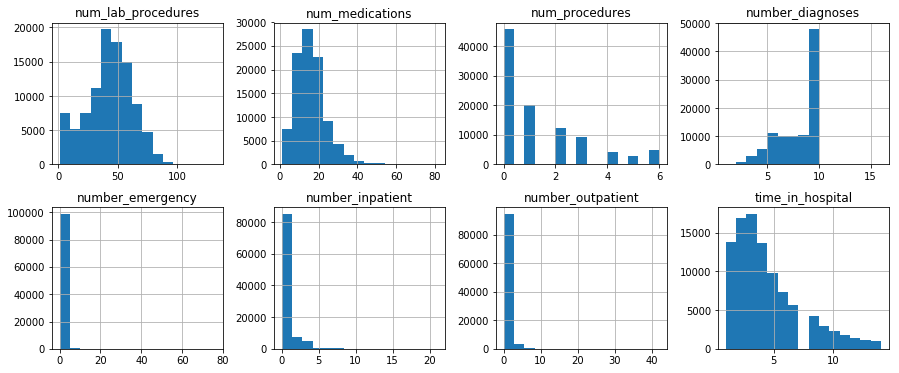

In [12]:
data[cols_num].hist(bins=15, figsize=(15, 6), layout=(2, 4));

In [13]:
### Nulls in numericall features ###
data[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

In [14]:
'''There is no 'null' in the numerical features'''

"There is no 'null' in the numerical features"

In [15]:
### List for categorical features ###
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

In [16]:
### Nulls in categorical features ###
data[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

In [17]:
'''race and payer_code have null values'''

'race and payer_code have null values'

In [18]:
### Handling na in race, payer_code, and medical_specialty ### 
data['race'] = data['race'].fillna('Null')
data['payer_code'] = data['payer_code'].fillna('Null')
data['medical_specialty'] = data['medical_specialty'].fillna('Null')

In [19]:
### Investigating distinct labels in medical_specialty ###
print('Number medical specialty:', data.medical_specialty.nunique())
data.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
Null                                 48616
InternalMedicine                     14237
Emergency/Trauma                      7419
Family/GeneralPractice                7252
Cardiology                            5279
Surgery-General                       3059
Nephrology                            1539
Orthopedics                           1392
Orthopedics-Reconstructive            1230
Radiologist                           1121
Pulmonology                            854
Psychiatry                             853
Urology                                682
ObstetricsandGynecology                669
Surgery-Cardiovascular/Thoracic        642
Gastroenterology                       538
Surgery-Vascular                       525
Surgery-Neuro                          462
PhysicalMedicineandRehabilitation      391
Oncology                               319
Pediatrics                             253
Neurology                              201
Hematology/Oncology                 

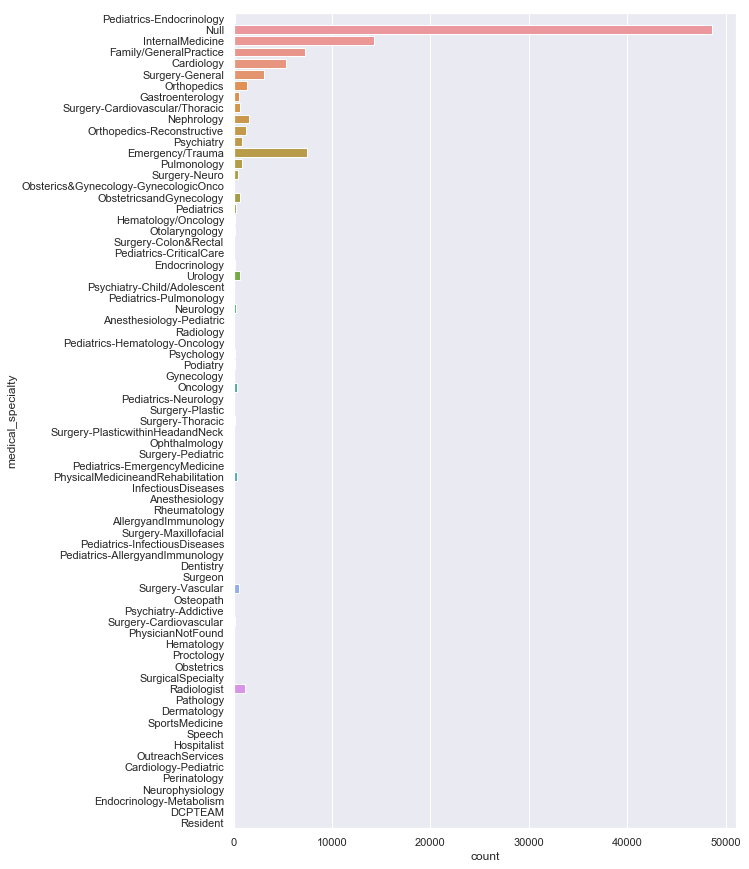

In [20]:
sns.set(rc={'figure.figsize':(9,15)})
sns.countplot(data = data, y = 'medical_specialty')

In [21]:
data.groupby('medical_specialty').size()

medical_specialty
AllergyandImmunology                        7
Anesthesiology                             12
Anesthesiology-Pediatric                   19
Cardiology                               5279
Cardiology-Pediatric                        7
DCPTEAM                                     5
Dentistry                                   4
Dermatology                                 1
Emergency/Trauma                         7419
Endocrinology                             119
Endocrinology-Metabolism                    8
Family/GeneralPractice                   7252
Gastroenterology                          538
Gynecology                                 58
Hematology                                 75
Hematology/Oncology                       187
Hospitalist                                57
InfectiousDiseases                         37
InternalMedicine                        14237
Nephrology                               1539
Neurology                                 201
Neurophysiology 

In [22]:
''' Using all 73 lables for the modeling can increse the dimensionality of the input features since we will use one hot encoder for categorical features. It results in increasing the complexity of models. There are 73 unique labels in 
medical_specialty. So, to avoid the mentioned issue and use this feature more efficintly, top 10 labels with high frequeancies are used directly in the modeling. The remaining lables are grouped and used as one single lable in the computation.'''

' Using all 73 lables for the modeling can increse the dimensionality of the input features since we will use one hot encoder for categorical features. It results in increasing the complexity of models. There are 73 unique labels in \nmedical_specialty. So, to avoid the mentioned issue and use this feature more efficintly, top 10 labels with high frequeancies are used directly in the modeling. The remaining lables are grouped and used as one single lable in the computation.'

In [23]:
### Top 10 labels with higher frequency ###
top_10 = ['Unknown','InternalMedicine','Emergency/Trauma','Family/GeneralPractice','Cardiology','Surgery-General','Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
data['med_spec'] = data['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
data.loc[~data.med_spec.isin(top_10),'med_spec'] = 'Other'

In [24]:
data.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                         56815
Radiologist                    1121
Surgery-General                3059
dtype: int64

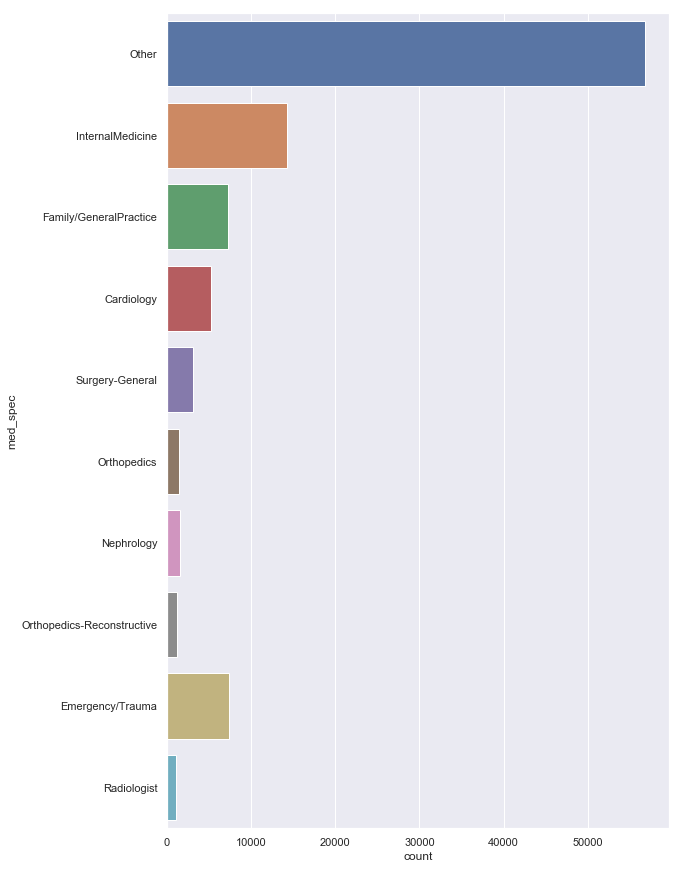

In [25]:
sns.set(rc={'figure.figsize':(9,15)})
sns.set(font scale=1.25)
sns.countplot(data = data, y = 'med_spec')

In [26]:
'''Now, instead of having 73 labels there are only 11 labels in the new created med_spec feature. '''

'Now, instead of having 73 labels there are only 11 labels in the new created med_spec feature. '

In [27]:
### Changing data type of categorical features with numerical labels to string ###
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
data[cols_cat_num] = data[cols_cat_num].astype('str')

In [28]:
### Sclaing numerical features to speed up the computations ###
from sklearn.preprocessing import StandardScaler
data[cols_num] = StandardScaler().fit_transform(data[cols_num])
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,med_spec
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,-1.138438,...,No,No,No,No,No,No,No,No,NO,Other
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,-0.464673,...,Up,No,No,No,No,No,Ch,Yes,>30,Other
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,-0.801555,...,No,No,No,No,No,No,No,Yes,NO,Other
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,-0.801555,...,Up,No,No,No,No,No,Ch,Yes,NO,Other
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,-1.138438,...,Steady,No,No,No,No,No,Ch,Yes,NO,Other


In [29]:
### Creating dummies from categorical features to use in the predictive models ###
data_cat = pd.get_dummies(data[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [30]:
data_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Null,race_Other,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,admission_source_id_9,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
### Joining Categorical features to the main dataset ###
data = pd.concat([data,data_cat], axis = 1)

In [32]:
### Creating a list of all categorical features ###
cols_all_cat = list(data_cat.columns)

In [33]:
### Handling age and weight features which are special features in this dataset ### 
data[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


In [34]:
data.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [35]:
### Creating new ids for 'age' feature with name 'age_group' ###
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
data['age_group'] = data.age.replace(age_id)

In [36]:
print('No patient weight reported:', data.weight.isnull().sum())
print('Patient weight reported:', data.weight.notnull().sum())

No patient weight reported: 96218
Patient weight reported: 3125


In [37]:
'''Patient weight is mostly missing'''

'Patient weight is mostly missing'

In [38]:
### Using 'weight' feature to create a new feature named 'has_weight' ###
data['has_weight'] = data.weight.notnull().astype('int')

In [39]:
### Create a list of  special features ###
cols_special = ['age_group','has_weight']

In [40]:
### Feature info after cleaning the data ###
print('Total number of features:', len(cols_num + cols_all_cat + cols_special))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_special))

Total number of features: 142
Numerical Features: 8
Categorical Features: 132
Extra features: 2


In [41]:
### Making sure there is no more null in the cleaned data ###
data[cols_num + cols_all_cat + cols_special].isnull().sum().sort_values(ascending = False).head(10)

has_weight              0
pioglitazone_No         0
acarbose_No             0
rosiglitazone_Up        0
rosiglitazone_Steady    0
rosiglitazone_No        0
pioglitazone_Up         0
pioglitazone_Steady     0
tolbutamide_Steady      0
acarbose_Up             0
dtype: int64

In [42]:
### Encoding multiclass target feature 'readmitted' ###
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data['readmitted'] = labelencoder.fit_transform(data['readmitted'])

In [43]:
### Finalizing dataset to use for modeling by adding label encoded target feature 'readmitted' ###
col2use = cols_num + cols_all_cat + cols_special
data_ready = data[col2use + ['readmitted']]
data_ready.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,age_group,has_weight,readmitted
0,-1.138438,-0.097243,-0.783565,-1.850439,-0.291863,-0.211622,-0.500575,-3.298145,0,1,...,0,0,0,0,1,0,0,0,0,2
1,-0.464673,0.820659,-0.783565,0.249657,-0.291863,-0.211622,-0.500575,0.823436,0,1,...,0,0,0,0,1,0,0,10,0,1
2,-0.801555,-1.627080,2.152815,-0.368019,1.288995,-0.211622,0.292810,-0.722157,0,0,...,0,0,0,0,1,0,0,20,0,2
3,-0.801555,0.055741,-0.196289,0.002587,-0.291863,-0.211622,-0.500575,-0.206960,0,1,...,0,0,0,0,1,0,0,30,0,2
4,-1.138438,0.412703,-0.783565,-0.985694,-0.291863,-0.211622,-0.500575,-1.237355,0,1,...,0,0,0,0,1,0,0,40,0,2


In [44]:
data_ready.shape

(99343, 143)

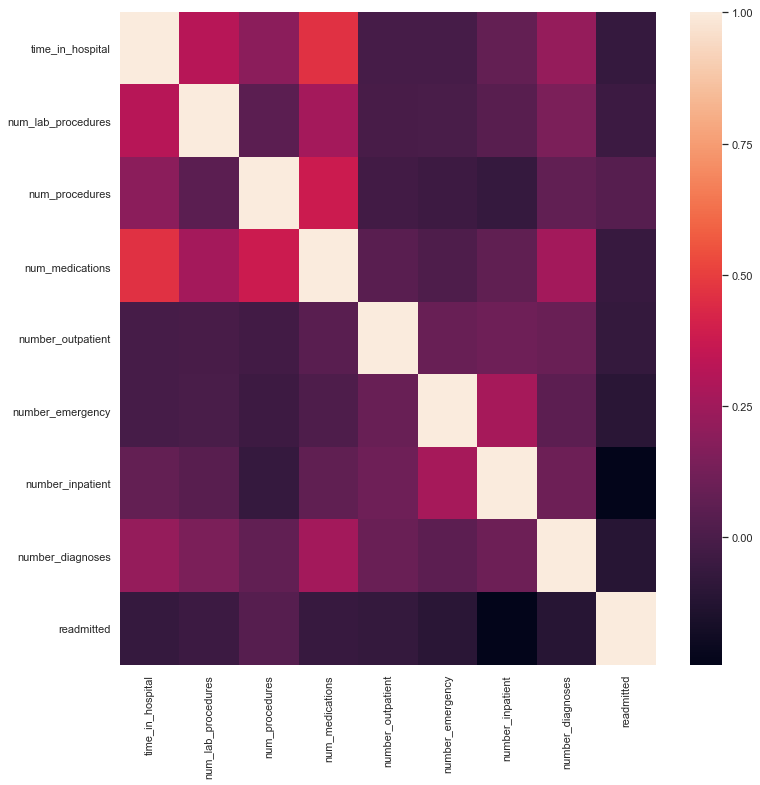

In [45]:
fig, x = plt.subplots(figsize=(12, 12))
corr = data_ready[cols_num + ['readmitted']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [46]:
corr

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
time_in_hospital,1.000000,0.319855,0.189908,0.463757,-0.009214,-0.009573,0.074251,0.220600,-0.063820
num_lab_procedures,0.319855,1.000000,0.051715,0.265148,-0.007610,-0.000980,0.039908,0.149663,-0.046945
num_procedures,0.189908,0.051715,1.000000,0.381931,-0.025263,-0.038715,-0.067021,0.070460,0.035732
num_medications,0.463757,0.265148,0.381931,1.000000,0.046037,0.014028,0.065266,0.261639,-0.057587
number_outpatient,-0.009214,-0.007610,-0.025263,0.046037,1.000000,0.091668,0.108015,0.094829,-0.070219
number_emergency,-0.009573,-0.000980,-0.038715,0.014028,0.091668,1.000000,0.267702,0.055994,-0.103762
number_inpatient,0.074251,0.039908,-0.067021,0.065266,0.108015,0.267702,1.000000,0.104737,-0.241909
number_diagnoses,0.220600,0.149663,0.070460,0.261639,0.094829,0.055994,0.104737,1.000000,-0.115187
readmitted,-0.063820,-0.046945,0.035732,-0.057587,-0.070219,-0.103762,-0.241909,-0.115187,1.000000


In [47]:
# Your data should be a pandas dataframe for this example
import pandas
yourdata = data_ready
corr_matrix = yourdata.corr()
print(corr_matrix["readmitted"].sort_values(ascending=True))
corr_matrix.to_csv('corr_matrix')

number_inpatient                      -0.241909
number_diagnoses                      -0.115187
number_emergency                      -0.103762
number_outpatient                     -0.070219
admission_source_id_7                 -0.068969
time_in_hospital                      -0.063820
num_medications                       -0.057587
diabetesMed_Yes                       -0.054354
discharge_disposition_id_22           -0.047810
discharge_disposition_id_6            -0.047515
num_lab_procedures                    -0.046945
age_group                             -0.041962
insulin_Up                            -0.040006
payer_code_MC                         -0.038392
metformin_No                          -0.037937
discharge_disposition_id_3            -0.035598
has_weight                            -0.032908
med_spec_Nephrology                   -0.031068
A1Cresult_None                        -0.027707
race_Caucasian                        -0.026353
max_glu_serum_>300                    -0

In [48]:
### splitting data into train and test sets ###
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data_ready[col2use], data_ready['readmitted'], test_size=test_size, random_state=0)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79474, 142)
(19869, 142)
(79474,)
(19869,)


In [50]:
### Using Gradinet Boosting Classifiaer to get feature importance ###
### Gradient boosting ###
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=200, learning_rate=0.10,
     max_depth=2, random_state=0)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [51]:
### Getting a list of feature importance ###
gbc_feature_importances = pd.DataFrame(gbc.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

([<matplotlib.axis.YTick at 0x1a2d5216ac8>,
 <a list of 20 Text yticklabel objects>)

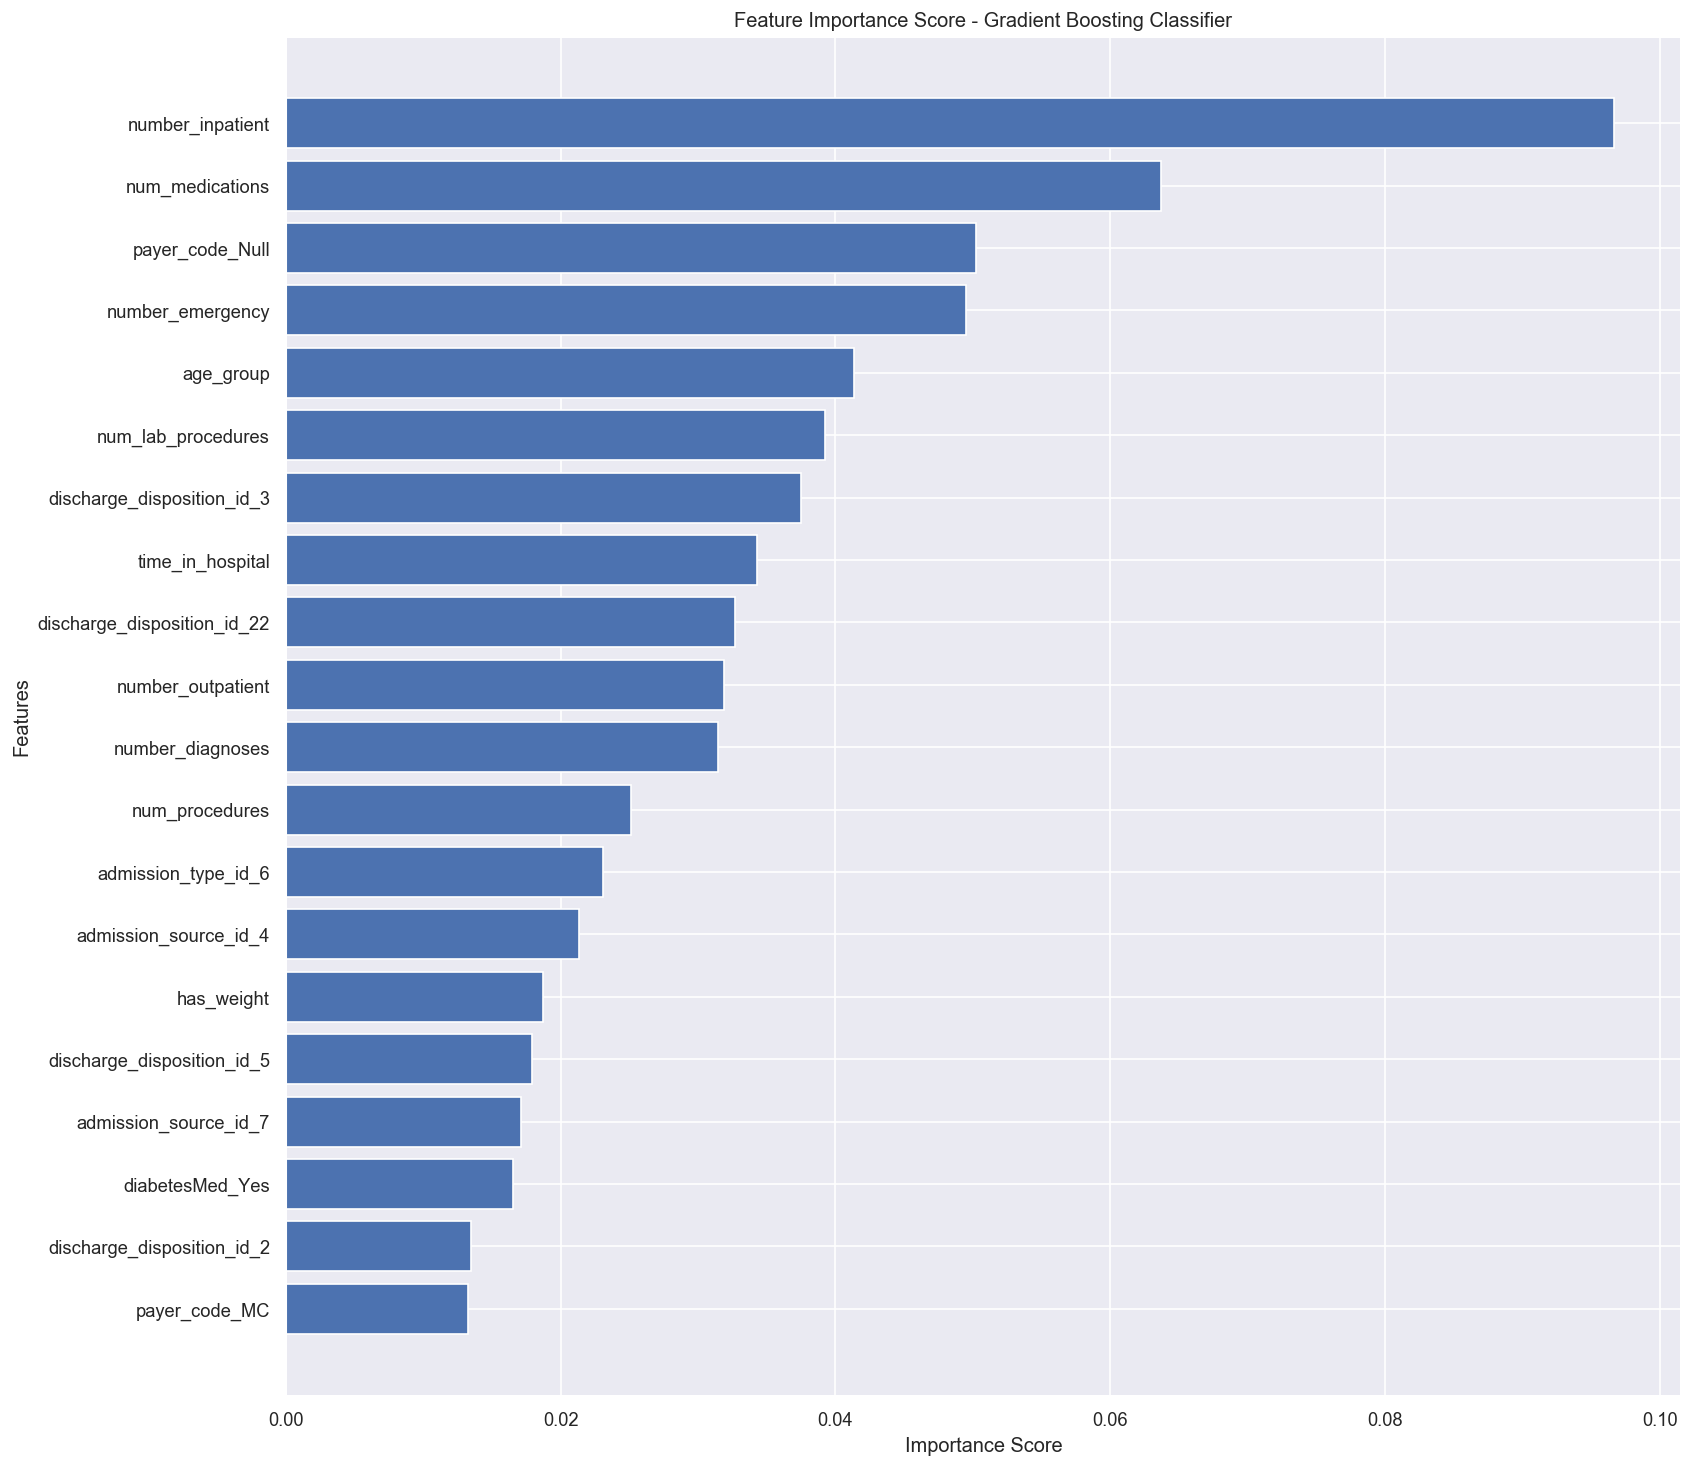

In [52]:
### Plotting 20 more important features ###
import matplotlib.pyplot as plt
num = 20
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = gbc_feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(gbc_feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(15, 15), dpi=120, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Gradient Boosting Classifier')
plt.yticks(ylocs, feature_labels)

In [53]:
### Creating a list of 20 most important features ###
important_features= gbc_feature_importances.iloc[:20].index

In [55]:
### Creating traning and testing dataset using 20 extracted important features ###
X_train_20F= X_train[important_features]
X_test_20F=X_test[important_features]

In [ ]:
### Training Sequential Neural Nets for classification using 20 most important features ###
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier_20F = Sequential()
# Adding the input layer and the first hidden layer
classifier_20F.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 20))
# Adding the second hidden layer
classifier_20F.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier_20F.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN
classifier_20F.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier_20F.fit(X_train_20F, y_train, batch_size = 32, epochs = 100)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/100
79474/79474 [==============================] - 8s 95us/step - loss: 0.9197 - accuracy: 0.5602
Epoch 2/100
79474/79474 [==============================] - 8s 98us/step - loss: 0.9014 - accuracy: 0.5725
Epoch 3/100
79474/79474 [==============================] - 9s 109us/step - loss: 0.8982 - accuracy: 0.5725
Epoch 4/100
79474/79474 [==============================] - 9s 111us/step - loss: 0.8968 - accuracy: 0.5743
Epoch 5/100
79474/79474 [==============================] - 9s 110us/step - loss: 0.8956 - accuracy: 0.5732
Epoch 6/100
79474/79474 [==============================] - 10s 124us/step - loss: 0.8953 - accuracy: 0.5737
Epoch 7/100
79474/79474 [==============================] - 9s 117us/step - loss: 0.8943 - accuracy: 0.5735
Epoch 8/100
79474/79474 [==============================] - 9s 112us/step - loss: 0.8946 - accuracy: 0.5748
Epoch 9/100
79474/79474 [==============================] - 9s 110us/step 

In [ ]:
### Training Sequential Neural Nets for classification using all the features ###
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier_full = Sequential()
# Adding the input layer and the first hidden layer
classifier_full.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 142))
# Adding the second hidden layer
classifier_full.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier_full.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN
classifier_full.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier_full.fit(X_train, y_train, batch_size = 32, epochs = 100)

In [ ]:
### Prediting testing dataset ###
NN_20F=classifier_20F.predict(X_test_20F)
NN__Full=classifier_full.predict(X_test)

In [ ]:
### Binarizing the target features ###
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_test, classes=[0, 1, 2])

In [ ]:
### Reporting ROC_AUC scores for both NN models ###
import sklearn
from sklearn.metrics import roc_auc_score
print('roc_auc score - NN with 20 Features:', sklearn.metrics.roc_auc_score(y_test, NN_20F))
print('roc_auc score - NN with Full Features:', sklearn.metrics.roc_auc_score(y_test, NN__Full))

In [ ]:
### Gradient boosting ###
from sklearn.ensemble import GradientBoostingClassifier
gbc_20F =GradientBoostingClassifier(n_estimators=200, learning_rate=0.10, max_depth=2, random_state=0)
gbc_20F.fit(X_train_20F, y_train)

In [ ]:
###Gradient boosting###
from sklearn.ensemble import GradientBoostingClassifier
gbc_Full =GradientBoostingClassifier(n_estimators=200, learning_rate=0.10, max_depth=2, random_state=0)
gbc_Full.fit(X_train, y_train)

In [ ]:
### Prediting testing dataset ###
gbc_20F_prediction = gbc_20F.predict(X_test_20F)
gbc_Full_prediction = gbc_Full.predict(X_test)

In [ ]:
### Binarizing the predicted target features with gbc ###
gbc_20F_prediction = label_binarize(gbc_20F_prediction, classes=[0, 1, 2])
gbc_Full_prediction = label_binarize(gbc_Full_prediction, classes=[0, 1, 2])

In [ ]:
### Reporting ROC_AUC scores for both gbc models ###
print('roc_auc score - gbc with 20 Features:', sklearn.metrics.roc_auc_score(y_test, gbc_20F_prediction))
print('roc_auc score - gbc with Full Features:', sklearn.metrics.roc_auc_score(y_test, gbc_Full_prediction))

In [ ]:
###Stochastic gradient descent###
from sklearn.linear_model import SGDClassifier
sgdc_20F=SGDClassifier(loss = 'log',alpha = 0.01, max_iter= 200, penalty= 'l1', random_state = 0)
sgdc_20F.fit(X_train_20F, y_train)

In [ ]:
### Stochastic gradient descent ###
from sklearn.linear_model import SGDClassifier
sgdc_Full=SGDClassifier(loss = 'log',alpha = 0.01, max_iter= 200, penalty= 'l1', random_state = 0)
sgdc_Full.fit(X_train, y_train)

In [ ]:
### Prediting testing dataset ###
sgdc_20F_prediction = sgdc_20F.predict(X_test_20F)
sgdc_prediction_full = sgdc_Full.predict(X_test)

In [ ]:
### Binarizing the predicted target features with gbc ###
sgdc_20F_prediction = label_binarize(sgdc_20F_prediction, classes=[0, 1, 2])
sgdc_prediction_full = label_binarize(sgdc_prediction_full, classes=[0, 1, 2])

In [ ]:
### Reporting ROC_AUC scores for both sgdc models ###
print('roc_auc score - sgdc with 20 Features:', sklearn.metrics.roc_auc_score(y_test, sgdc_20F_prediction))
print('roc_auc score - sgdc with Full Features:', sklearn.metrics.roc_auc_score(y_test, sgdc_prediction_full))

In [ ]:
###RandomForestClassifier###
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_20F = RandomForestClassifier(n_estimators= 500, bootstrap = True, min_samples_split= 6, max_depth= 8, max_features ='auto' )
# Fit on training data
rf_20F.fit(X_train_20F, y_train)

In [ ]:
###RandomForestClassifier###
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_Full = RandomForestClassifier(n_estimators= 500, bootstrap = True, min_samples_split= 6, max_depth= 8, max_features ='auto' )
# Fit on training data
rf_Full.fit(X_train, y_train)

In [ ]:
### Prediting testing dataset ###
rf_prediction_20F = rf_20F.predict(X_test_20F)
rf_prediction_Full = rf_Full.predict(X_test)

In [ ]:
### Binarizing the predicted target features with gbc ###
rf_prediction_20F = label_binarize(rf_prediction_20F, classes=[0, 1, 2])
rf_prediction_Full = label_binarize(rf_prediction_Full, classes=[0, 1, 2])

In [ ]:
### Reporting ROC_AUC scores for both sgdc models ###
print('roc_auc score - RandomForest with 20 Features:', sklearn.metrics.roc_auc_score(y_test, rf_prediction_20F))
print('roc_auc score - RandomForest with Full Features:', sklearn.metrics.roc_auc_score(y_test, rf_prediction_Full))

In [ ]:
### Multiclass ROC curve for SGDClassifier ###
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
SGDClassifier(loss = 'log',alpha = 0.01, max_iter= 200, penalty= 'l1', random_state = 0)
# Import some data to play with
X = data_ready[important_features]
y = data_ready['readmitted']

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SGDClassifier(loss = 'log',alpha = 0.01, max_iter= 200, penalty= 'l1', random_state = 0)) 
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
### ### ROC curve for SGDClassifier ###
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.close()
# Plot all ROC curves

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.rcParams["figure.figsize"] = [9,6]

In [ ]:
### Multiclass ROC curve for GradientBoostingClassifier ###
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
# Import some data to play with
X = data_ready[important_features]
y = data_ready['readmitted']

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=200, learning_rate=0.10, max_depth=2, random_state=0)) 
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
### ROC curve for GradientBoostingClassifier ###
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.rcParams["figure.figsize"] = [9,9]

In [ ]:
### Multiclass ROC curve for RandomForestClassifier ###
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import some data to play with
X = data_ready[important_features]
y = data_ready['readmitted']

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators= 500, bootstrap = True, min_samples_split= 6, max_depth= 8, max_features ='auto' )) 
rf = classifier.fit(X_train, y_train)
y_score = rf.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
### ROC curve for GradientBoostingClassifier ###
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.rcParams["figure.figsize"] = [9,6]

In [ ]:
### Multiclass ROC curve for GradientBoostingClassifier ###
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import some data to play with
X = data_ready[important_features]
y = data_ready['readmitted']

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier_20F = Sequential()
# Adding the input layer and the first hidden layer
classifier_20F.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 20))
# Adding the second hidden layer
classifier_20F.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier_20F.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN
classifier_20F.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
# Learn to predict each class against the other
classifier = OneVsRestClassifier(classifier.fit(X_train, y_train)) 
nn = classifier.fit(X_train, y_train)
y_score = nn.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
'''
### Training Sequential Neural Nets for classification using 20 most important features ###
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier_20F = Sequential()
# Adding the input layer and the first hidden layer
classifier_20F.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 20))
# Adding the second hidden layer
classifier_20F.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier_20F.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
# Compiling the ANN
classifier_20F.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier_20F.fit(X_train_20F, y_train, batch_size = 32, epochs = 100)
'''

In [ ]:
### ROC curve for GradientBoostingClassifier ###
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.rcParams["figure.figsize"] = [9,12]